# Neural Style Transfer
-----------------------
### Paper: [A Neural Algorithm of Artistic Style (Gatys et al., 2015)](https://arxiv.org/pdf/1508.06576.pdf)

Import libraries.

In [ ]:
# Notebook display
from tqdm import tqdm
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyTorch
import torch
from torch.optim import LBFGS
from torchvision import transforms
from torch.hub import load_state_dict_from_url
from torch.nn import Module, Conv2d, AvgPool2d, ReLU

Define constants and image processing functions.

In [ ]:
# Image size
SIZE = 1024

# ImageNet statistics
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, normalize=True, mean=MEAN, std=STD):
    resize = transforms.Compose([transforms.Resize(SIZE, Image.LANCZOS),
                                 transforms.CenterCrop(SIZE)])
    norm = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])
    image = resize(image)
    if normalize:
        return norm(image).unsqueeze(0).to(DEVICE)
    return image

# Post-processing
def post(tensor, mean=MEAN, std=STD):
    mean, std = torch.tensor(mean).view(3, 1, 1), torch.tensor(std).view(3, 1, 1)
    tensor = transforms.Lambda(lambda x: x * std + mean)(tensor.cpu().clone().squeeze(0))
    return transforms.ToPILImage()(tensor.clamp_(0, 1))

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, normalize=False))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, normalize=False))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

Load content and style images.

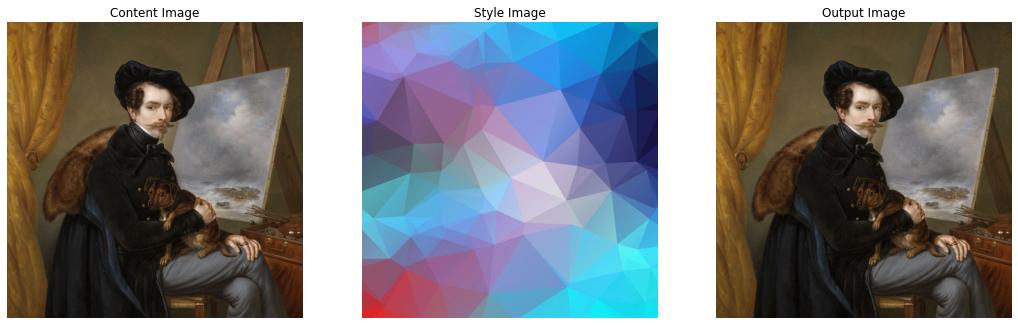

In [ ]:
# Manually upload the images
files.upload()
clear_output()

# Open and prepare images
content_image, style_image = Image.open('painter.jpg'), Image.open('abstract.jpg')
content, style = prep(content_image), prep(style_image)
input = content.clone()

# Display images
_ = draw(input, content_image, style_image)

Define content and style losses.

In [ ]:
class ContentLoss(Module):
    def forward(self, features, targets):
        loss = (features - targets).pow(2)
        return loss.mean()


class StyleLoss(Module):
    def forward(self, features, GM_t):
        GM_f = self.gram_matrix(features)
        loss = (GM_f - GM_t).pow(2)
        return loss.mean()
    
    @staticmethod
    def gram_matrix(inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(C, H * W)
        GM = inputs.mm(inputs.t())
        return GM.div_(H * W)

VGG-19 (with average pooling for better image synthesis).

Paper: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [ ]:
class VGG19(Module):
    def __init__(self):
        super().__init__()

        # Feature Extractor
        self.conv1_1 = Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv2_1 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv3_1 = Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv4_1 = Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv5_1 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 =   AvgPool2d(kernel_size=2, stride=2)

        # Activation function
        self.relu = ReLU()

        # Freeze Parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x, out_layers):
        out = dict()

        out['conv1_1'] = self.relu(self.conv1_1(x))
        out['conv1_2'] = self.relu(self.conv1_2(out['conv1_1']))
        out['pool1'] = self.pool1(out['conv1_2'])

        out['conv2_1'] = self.relu(self.conv2_1(out['pool1']))
        out['conv2_2'] = self.relu(self.conv2_2(out['conv2_1']))
        out['pool2'] = self.pool2(out['conv2_2'])

        out['conv3_1'] = self.relu(self.conv3_1(out['pool2']))
        out['conv3_2'] = self.relu(self.conv3_2(out['conv3_1']))
        out['conv3_3'] = self.relu(self.conv3_3(out['conv3_2']))
        out['conv3_4'] = self.relu(self.conv3_4(out['conv3_3']))
        out['pool3'] = self.pool3(out['conv3_4'])

        out['conv4_1'] = self.relu(self.conv4_1(out['pool3']))
        out['conv4_2'] = self.relu(self.conv4_2(out['conv4_1']))
        out['conv4_3'] = self.relu(self.conv4_3(out['conv4_2']))
        out['conv4_4'] = self.relu(self.conv4_4(out['conv4_3']))
        out['pool4'] = self.pool4(out['conv4_4'])

        out['conv5_1'] = self.relu(self.conv5_1(out['pool4']))
        out['conv5_2'] = self.relu(self.conv5_2(out['conv5_1']))
        out['conv5_3'] = self.relu(self.conv5_3(out['conv5_2']))
        out['conv5_4'] = self.relu(self.conv5_4(out['conv5_3']))
        out['pool5'] = self.pool5(out['conv5_4'])

        return [out[layer] for layer in out_layers]

Load pretrained VGG-19 weights & biases.



In [ ]:
vgg19 = VGG19().to(DEVICE)

state = vgg19.state_dict()
pretrained_vgg19 = 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
new_state_values = list(load_state_dict_from_url(pretrained_vgg19).values())

for i, value in enumerate(state):
    state[value] = new_state_values[i]

vgg19.load_state_dict(state)

Pre-compute targets and initialize losses.

In [ ]:
# Layers of Content/Style reconstruction
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
loss_layers = content_layers + style_layers

# Targets
content_targets = [targets.detach() for targets in vgg19(content, content_layers)]
style_targets = [StyleLoss.gram_matrix(targets).detach() for targets in vgg19(style, style_layers)]
targets = content_targets + style_targets

# Losses
losses = [ContentLoss()] * len(content_layers) + [StyleLoss()] * len(style_layers)

# Loss weights
content_weights = [1] * len(content_layers)
style_weights = [1e3] * len(style_layers)
loss_weights = content_weights + style_weights

Transfer style.

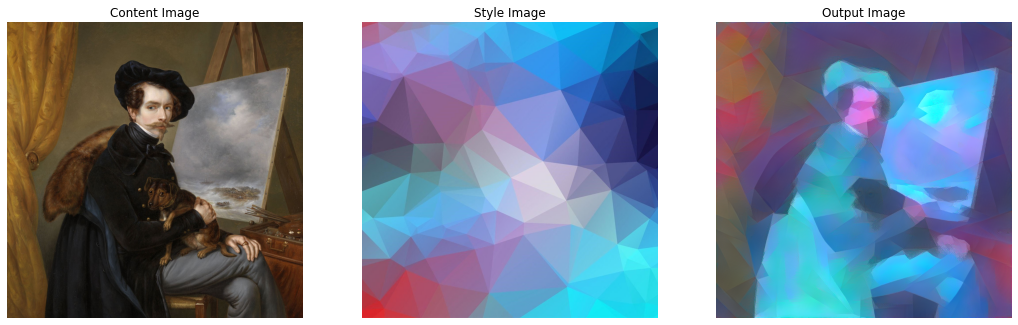

100%|██████████| 20/20 [02:44<00:00,  8.21s/it]


In [ ]:
def transfer_style(model, input, targets, losses, loss_weights, iterations=20):
    optimizer = LBFGS([input.requires_grad_()])
    for iteration in tqdm(range(1, iterations + 1)):
        def closure():
            optimizer.zero_grad()
            out = model(input, loss_layers)
            total_loss = sum([loss_weights[i] * losses[i](features, targets[i]) for i, features in enumerate(out)])
            total_loss.backward()
            return total_loss
        optimizer.step(closure)

        if iteration % 5 == 0:
            output = draw(input, content_image, style_image)

    return output

# Run
output = transfer_style(vgg19, input, targets, losses, loss_weights)

Save and download output.

In [ ]:
output.save('output.png')
files.download('output.png')